In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataSorted = np.genfromtxt("runtime_hdd_sorted.csv", delimiter=",")
dataUnsorted = np.genfromtxt("runtime_hdd_unsorted.csv", delimiter=",")

# Test con datos ordenados
Como la función de hash es muy propensa a tener colisiones en la tabla, esto es un mejor caso de uso al insertar palabras. 

<BarContainer object of 26 artists>

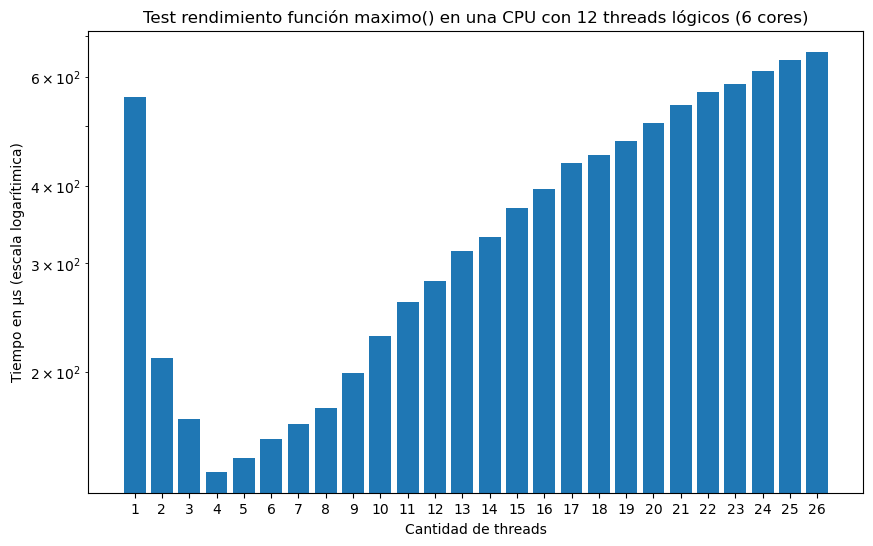

In [3]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento función maximo() en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.bar(dataSorted[:,0], dataSorted[:,1])

<BarContainer object of 26 artists>

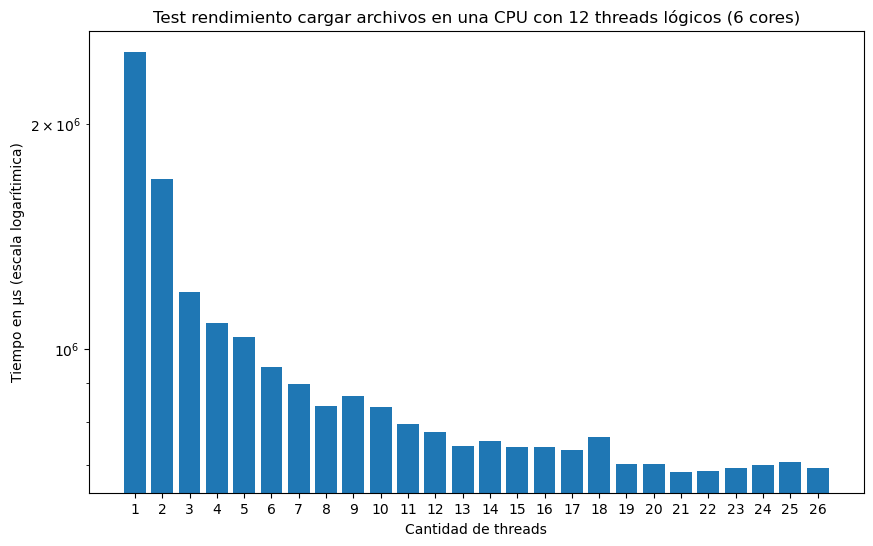

In [4]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento cargar archivos en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.bar(dataSorted[:,0], dataSorted[:,2])

# Test con datos desordenados
Como la función de hash es muy propensa a tener colisiones en la tabla, esto es un peor caso de uso al insertar palabras. 

<BarContainer object of 26 artists>

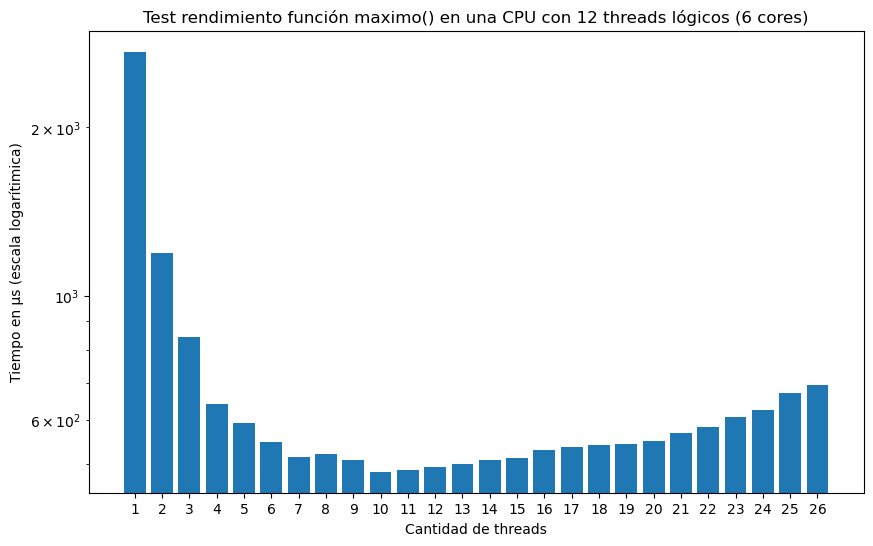

In [5]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento función maximo() en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.bar(dataUnsorted[:,0], dataUnsorted[:,1])

<BarContainer object of 26 artists>

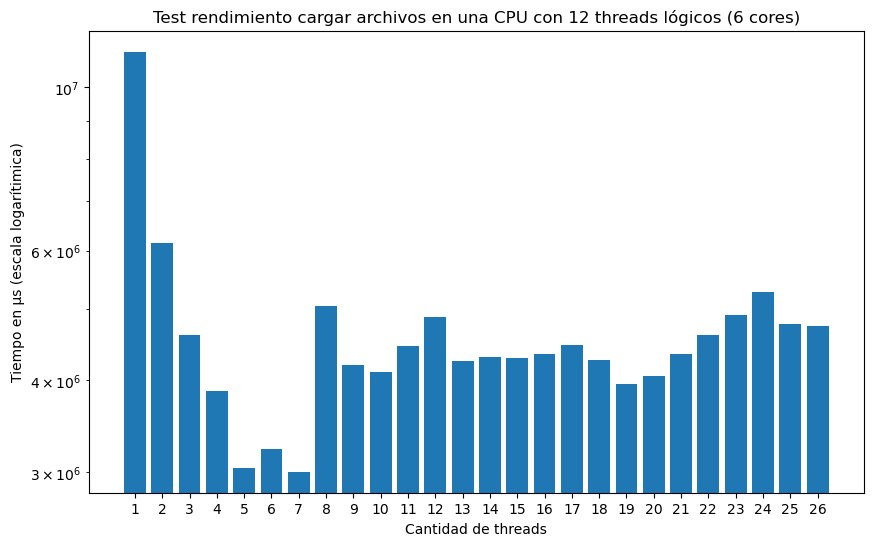

In [6]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento cargar archivos en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.bar(dataUnsorted[:,0], dataUnsorted[:,2])

# Gráficos combinados
No sé, me divierte hacer gráficos

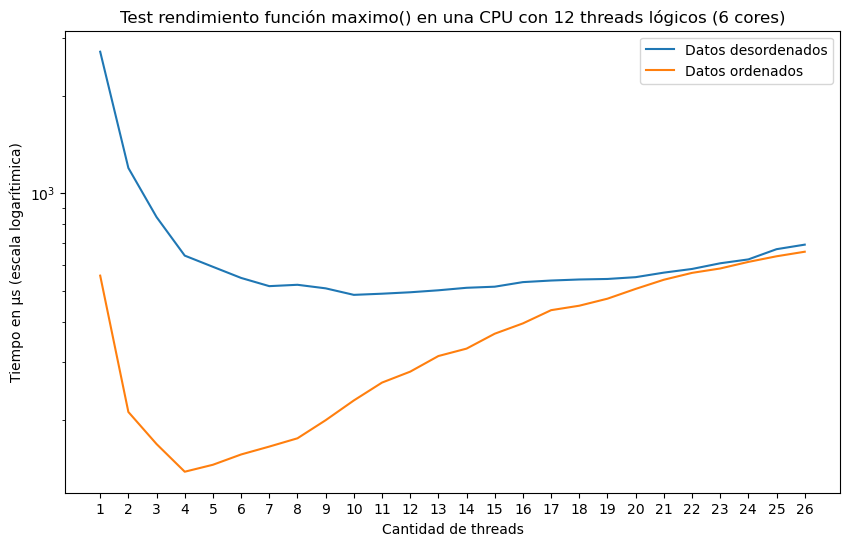

In [11]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento función maximo() en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.plot(dataUnsorted[:,0], dataUnsorted[:,1], label="Datos desordenados")
plt.plot(dataSorted[:,0], dataSorted[:,1], label="Datos ordenados")
plt.legend(loc='upper right')
plt.savefig("test_maximo.png")
plt.show()

Me parece muy raro que esto dé más rápido con datos ordenados también. Se supone que la función máximo recorre toda la tabla. Será que al agregarse los datos mucho más rápido (ver gráfico de abajo) quedó mucha más información en la caché de nivel 3? Esta cpu según la hoja de datos de AMD tiene 32MB de caché L3 y el diccionario entero ocupa menos de 2MB.

De última solo incluímos los resultados de los datos ordenados vs desordenados para la carga y el máximo solo presentamos un test. No, sé. Es muy tarde.

<img src="https://i.kym-cdn.com/entries/icons/original/000/038/013/cover4.jpg" alt="pichi ikari" width="500"/>

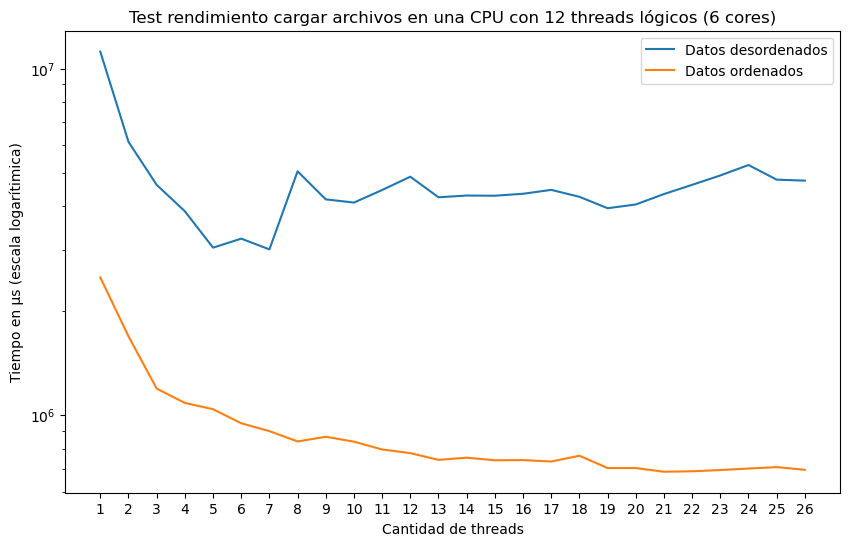

In [8]:
plt.figure(figsize=(10,6))
plt.xticks(dataSorted[:,0])
#plt.xscale("log")
plt.title("Test rendimiento cargar archivos en una CPU con 12 threads lógicos (6 cores)")
plt.xlabel("Cantidad de threads")
plt.ylabel("Tiempo en μs (escala logarítimica)")
plt.yscale("log")
plt.plot(dataUnsorted[:,0], dataUnsorted[:,2], label="Datos desordenados")
plt.plot(dataSorted[:,0], dataSorted[:,2], label="Datos ordenados")
plt.legend(loc='upper right')
plt.savefig("test_carga.png")
plt.show()

Acá se ve como las colisiones de hash nos juega en contra con las palabras desordenadas. También es curioso el resultado de datos ordenados cuando la cantidad de threads incluso supera los threads lógicos del procesador. Será que al hacer muchos fopen en simultáneo se reducen los tiempos de espera? El diccionario estaba partido en 26 chunks de 75KB.

# Información de un profiler
Como los resultados de la función máximo() en el caso de las palabras ordenadas resultaron mejor de lo esperado, corrimos los dos casos con un profiler para investigar el hit-rate de caché con ambos sets de datos. Caudno se habla de cache-misses el profiler no hace distinción entre niveles de caché en un sistema con múltiples jerarquías de caché para la CPU.

## Caso ordenado
<img src="perf_sorted.png" alt="perf sorted" width="500"/> 

## Caso desordenado
<img src="perf_unsorted.png" alt="perf unsorted" width="500"/>

Como se puede observar el hit-rate de la corrida del programa con las palabras ordenadas entre los archivos es mucho mayor que la de los desordenadas. Esto incluye tanto la parte de abrir y cargar todos los archivos, y la de encontrar el máximo en paralelo. También, es razonable que en ambos el operador == sea el que mayor cache-misses tiene. Este es un programa muy intesivo en operaciones en memoria, la mayoría de las operaciones consisten en realizar copias en memoria (carga de archivos) y comparaciones de strings (operador == y _memcmp_avx2_movbe).

Con esto se puede confirmar nuestra sospecha que insertar las palabras en órden resulta en una mejor congruencia en memoria y por ende un mayor hit-rate para el caso de encontrar el máximo en la tabla.